In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from PIL import Image, ImageFile, ImageDraw
from torchvision.transforms import v2
import torchvision as tv

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cards-image-datasetclassification


In [8]:
! ls /kaggle/input/cards-image-datasetclassification

'14card types-14-(200 X 200)-94.61.h5'	 cards.csv   train
'53cards-53-(200 X 200)-100.00.h5'	 test	     valid


In [9]:
df=pd.read_csv('/kaggle/input/cards-image-datasetclassification/cards.csv')
df.drop(columns=["data set"],inplace=True)
df

,class index,filepaths,labels,card type
0,0,train/ace of clubs/001.jpg,ace of clubs,ace
1,0,train/ace of clubs/002.jpg,ace of clubs,ace
2,0,train/ace of clubs/003.jpg,ace of clubs,ace
3,0,train/ace of clubs/004.jpg,ace of clubs,ace
4,0,train/ace of clubs/005.jpg,ace of clubs,ace
...,...,...,...,...
8150,52,valid/two of spades/1.jpg,two of spades,two
8151,52,valid/two of spades/2.jpg,two of spades,two
8152,52,valid/two of spades/3.jpg,two of spades,two
8153,52,valid/two of spades/4.jpg,two of spades,two


In [43]:
dindices=[]
i=0
for item in df["filepaths"]:
  if(item[-4:]!=".jpg"):dindices.append(i)
  i+=1
  #break
print(len(dindices))
df.drop(dindices,inplace=True)

1


In [44]:
df['class index'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52])

In [45]:
df['labels'].unique().shape


(53,)

In [46]:
df['labels'].value_counts()

,count
labels,
ace of spades,191
jack of spades,182
ace of hearts,181
jack of clubs,181
jack of hearts,178
seven of spades,175
queen of diamonds,173
queen of spades,172
queen of clubs,171


In [47]:
labels=df["labels"].unique().tolist()
for item in labels:
  first=df[df["labels"]==item].iloc[0]
  img=Image.open(path+"/"+first["filepaths"])
  print(item)
  display(img)
  print(img.size)
  print("\n-----------------------------------------------------------\n")
  #break

Output hidden; open in https://colab.research.google.com to view.

In [48]:
np.array(img).shape

(224, 224, 3)

In [49]:
lab_sets={x:df[df["labels"]==x] for i,x in enumerate(labels)}


In [51]:
#train_sets={x:train_test_split(lab_sets[x],test_size=0.3, random_state=42) for i,x in enumerate(labels)}
trains,vals,tests=[],[],[]
for x in labels:
  train, preval=train_test_split(lab_sets[x],test_size=0.3, random_state=42)
  val,test=train_test_split(preval,test_size=0.5, random_state=42)
  #sets[x]=[train,val,test]
  trains.append(train)
  vals.append(val)
  tests.append(test)

train_sets=pd.concat(trains)
val_sets=pd.concat(vals)
test_sets=pd.concat(tests)


In [52]:
class Card_dataset(Dataset):
    def __init__(self,original_path, df, transform=None):
        self.df = df
        self.transform = transform
        self.opath=original_path

        self.mean=torch.tensor([0.485, 0.456, 0.406])
        self.std=torch.tensor([0.229, 0.224, 0.225])

        self.stdzer = tv.transforms.Normalize(self.mean, self.std, inplace=False)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        label = self.df.iloc[idx]["class index"].astype(np.int64)
        image = self.opath+self.df.iloc[idx]["filepaths"]
        image = tv.transforms.functional.pil_to_tensor(Image.open(image)).type(torch.float32)
        image=image/255

        if self.transform:
            image = self.transform(image)

        image=self.stdzer(image)


        return image, label

In [53]:
tfs=tv.transforms.Compose([tv.transforms.RandomAutocontrast(p=0.4),tv.transforms.v2.RandomEqualize(p= 0.4),tv.transforms.v2.RandomAdjustSharpness(0, p= 0.4),tv.transforms.v2.RandomAdjustSharpness(2, p = 0.4),v2.RandomApply([v2.GaussianBlur(11, sigma=(0.1, 2.0))],p=0.5),v2.RandomRotation(degrees=(0, 180)),v2.RandomApply([v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))],p=0.2),v2.RandomHorizontalFlip(p=0.5),v2.RandomVerticalFlip(p=0.5),tv.transforms.v2.RandomGrayscale(p= 0.1),v2.RandomApply([v2.ColorJitter(brightness=(0.1,1), contrast=0.4,saturation=0.4)],p=0.2),v2.Resize((256,256))])

In [54]:
Train_set=Card_dataset(path+"/",train_sets,tfs)
Val_set=Card_dataset(path+"/",val_sets)
Test_set=Card_dataset(path+"/",test_sets)

In [55]:
train_dataloader = DataLoader(Train_set, batch_size=128, shuffle=True,num_workers=4,pin_memory=True)
val_dataloader = DataLoader(Val_set, batch_size=256, shuffle=False,num_workers=4,pin_memory=True)
test_dataloader = DataLoader(Test_set, batch_size=256, shuffle=False,num_workers=4,pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [56]:
class Card_recognizer(nn.Module):
    def __init__(self):
        super(Card_recognizer, self).__init__()

        self.resnet=models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad=False

        self.relu=torch.nn.ReLU()
        self.Dropout=torch.nn.Dropout(0.4)
        self.fc1=torch.nn.Linear(1000,256)
        self.fc2=torch.nn.Linear(256,53)

    def forward(self,x):
        x=self.resnet(x)
        x=self.relu(x)
        x=self.Dropout(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.Dropout(x)
        x=self.fc2(x)
        return x

    def freeze_resnet(self):
        for param in self.resnet.parameters():
            param.requires_grad=False
    def unfreeze_resnet(self):
        for param in self.resnet.parameters():
            param.requires_grad=True

In [57]:
#model=models.resnet18(pretrained=True)
#model

In [58]:
#model
torch.cuda.is_available()

True

In [59]:
if(torch.cuda.is_available()):
  device=torch.device("cuda")
else:
  device=torch.device("cpu")
print(device)

cuda


In [60]:
model=Card_recognizer()
model(torch.randn((1,3,100,100,)))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[-0.0125,  0.2192,  0.0759,  0.3232,  0.0310,  0.2415, -0.0921, -0.2008,
         -0.1634,  0.0475,  0.0996,  0.0438, -0.3539, -0.0985, -0.1689, -0.4461,
          0.1147, -0.3799, -0.0303, -0.1640,  0.1279,  0.0466, -0.1351, -0.0685,
          0.1511, -0.2512, -0.0659, -0.0754, -0.1410, -0.0762,  0.1969, -0.0289,
         -0.1395, -0.0247,  0.2290,  0.1543, -0.1387, -0.2292, -0.1885,  0.0798,
         -0.1857,  0.1081,  0.1244, -0.0971, -0.3836, -0.2316, -0.2769, -0.1760,
         -0.3866, -0.0318,  0.1490, -0.2307, -0.0542]],
       grad_fn=<AddmmBackward0>)

In [61]:
if(device.type!="cpu"):
  model=model.to("cuda")
  model=model.to(device)

In [62]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0

    def call(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return False
    def save(self, val_loss):
        if self.best_loss is None:
            return True
        elif val_loss > self.best_loss - self.delta:
            return False

In [66]:
optimizer=torch.optim.AdamW(model.parameters(),lr=0.001,weight_decay=0.02)
#optimizer=torch.optim.SGD(model.parameters(),lr=0.00001,momentum=0.75,weight_decay=0.1,nesterov=True)
loss_fn=torch.nn.MSELoss()
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,0.5)
loss_fn=torch.nn.CrossEntropyLoss()

In [67]:
num_epochs = 500
early_stopping = EarlyStopping(patience=20, delta=0.01)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_weights=None

In [70]:
model.unfreeze_resnet()

In [71]:
for epoch in range(num_epochs):
    # Tanítás
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().cpu().item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        #print(predicted.eq(labels).sum().item())
        #break
    train_loss = running_loss / (len(train_dataloader)*128)
    train_accuracy = 100. * correct / total

    # Validáció
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_running_loss += loss.detach().cpu().item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            #break
    val_loss = val_running_loss / (len(val_dataloader)*128)
    val_accuracy = 100. * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')


    if(early_stopping.save(val_accuracy)):
        best_weights=model.state_dict().copy()

    if early_stopping.call(val_accuracy):
        print("Korai leállítás aktiválva.")
        break
    if((epoch+1)%5==0):scheduler.step()

    #break


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1, Train Loss: 0.0191, Val Loss: 0.0153, Train Acc: 26.32%, Val Acc: 38.82%
Epoch 2, Train Loss: 0.0161, Val Loss: 0.0143, Train Acc: 35.38%, Val Acc: 42.42%
Epoch 3, Train Loss: 0.0144, Val Loss: 0.0122, Train Acc: 42.56%, Val Acc: 50.94%
Epoch 4, Train Loss: 0.0133, Val Loss: 0.0119, Train Acc: 47.54%, Val Acc: 49.88%
Epoch 5, Train Loss: 0.0123, Val Loss: 0.0106, Train Acc: 51.07%, Val Acc: 56.67%
Epoch 6, Train Loss: 0.0112, Val Loss: 0.0106, Train Acc: 55.05%, Val Acc: 52.91%
Epoch 7, Train Loss: 0.0105, Val Loss: 0.0094, Train Acc: 58.60%, Val Acc: 62.00%
Epoch 8, Train Loss: 0.0098, Val Loss: 0.0091, Train Acc: 61.40%, Val Acc: 63.23%
Korai leállítás aktiválva.


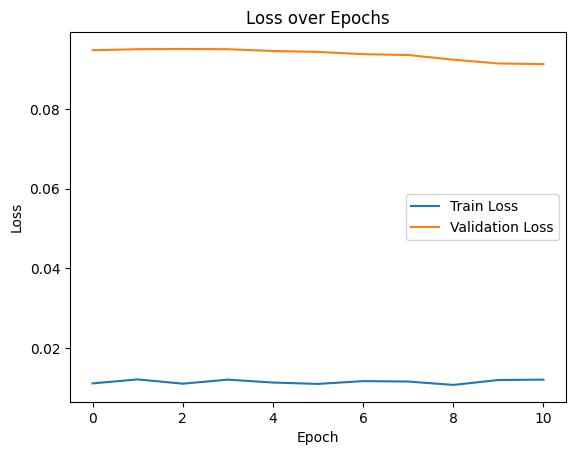

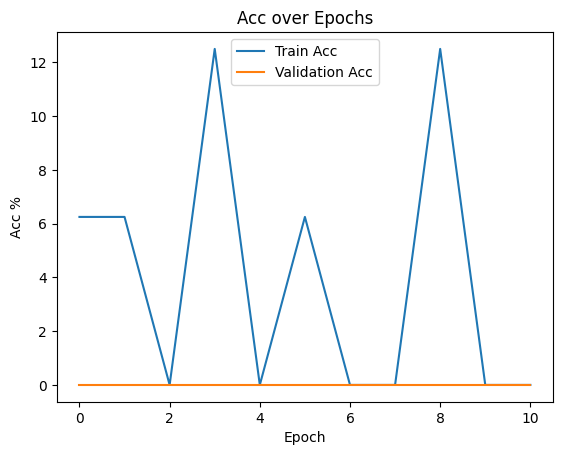

In [161]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc %')
plt.title('Acc over Epochs')
plt.legend()
plt.show()

In [164]:
def evaluate_model(loader, name):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [165]:
test_labels, test_preds = evaluate_model(test_dataloader, "Test")

In [182]:
def cm(all_labels, all_preds,name):
  fig,ax=plt.subplots(figsize=(20,20))
  #cm = confusion_matrix(all_labels, all_preds)
  disp = ConfusionMatrixDisplay.from_predictions(all_labels, all_preds,ax=ax)
  #disp.plot()
  plt.title(f'Confusion Matrix - {name}')
  plt.show()

  print(f"Classification Report for {name}:")
  print(classification_report(all_labels, all_preds))

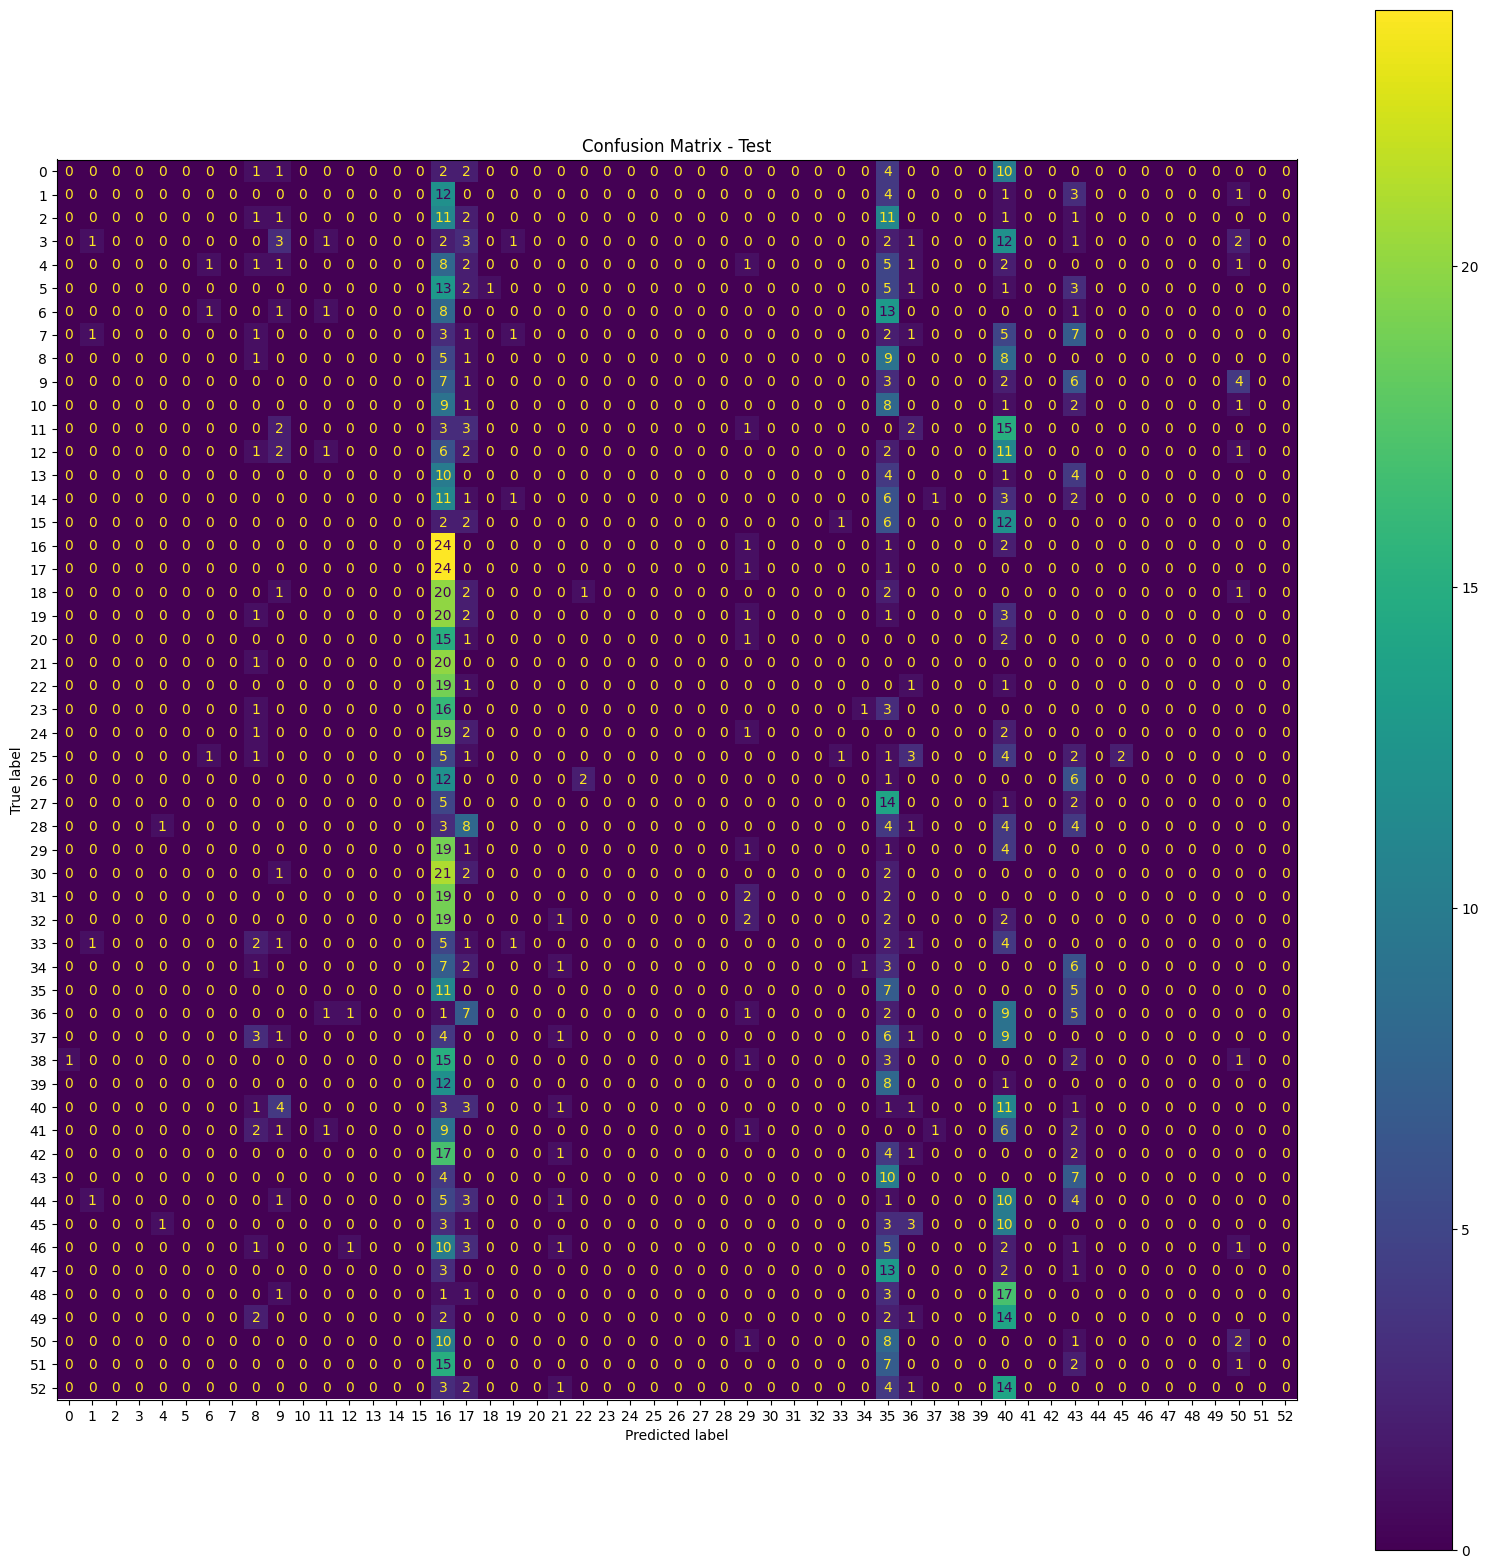

Classification Report for Test:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        26
           6       0.33      0.04      0.07        25
           7       0.00      0.00      0.00        22
           8       0.04      0.04      0.04        24
           9       0.00      0.00      0.00        23
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00        26
          13       0.00      0.00      0.00        19
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        23
          16       0.05      0.86      0.09      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [183]:
cm(test_labels, test_preds,"Test")

In [27]:
Train_set.__len__()

5684

In [28]:
5684/64

88.8125